# Data Exploration and Preparation

## **SpaceX  Falcon 9 First Stage Landing Prediction**

Here, we will perform Exploratory Data Analysis and prepare the data for model development through Feature Engineering.

## **Table of Contents**

[Exploratory Data Analysis](#Exploratory)

* [Percentage of missing values in each attribute](#Percentage_missing)
* [Number of launches on each site](#Launches_per_site)
* [Number of launches using each orbit](#Launches_orbit)
* [The relationship between flight number and payload mass](#Flight_number_payload)
* [Launch success rate](#Launch_success_rate)
* [The relationship between flight number and launch site](#Flight_number_site)
* [ The relationship between payload mass and launch site](#Payload_launch_site)
* [Launch success yearly trend](#Launch_success_trend)


[Feature Engineering](#Feature_engineering)

* [Creating dummy variables from categorical predictors](#Dummy)
* [Casting all encoded features to the numeric type `float64`](#Float64)


### Import Libraries and Define Auxiliary Functions


We will import the following libraries the lab

In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
#NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns

***

## Exploratory Data Analysis <a id='Exploratory'></a>

First, let's read the SpaceX dataset into a Pandas dataframe and print its summary


In [3]:
# df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
df=pd.read_csv("dataset_part_2.csv")
df.tail(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
160,161,2022-08-09,Falcon 9,13260.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3033383ecb075134e7cd,5.0,2,B1073,-80.603956,28.608059,1
161,162,2022-08-12,Falcon 9,13260.0,VLEO,VAFB SLC 4E,True ASDS,10,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,9,B1061,-120.610829,34.632093,1
162,163,2022-08-19,Falcon 9,13260.0,VLEO,CCSFS SLC 40,True ASDS,9,True,True,True,5e9e3033383ecb075134e7cd,5.0,8,B1062,-80.577366,28.561857,1
163,164,2022-08-28,Falcon 9,13260.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3033383ecb075134e7cd,5.0,1,B1069,-80.603956,28.608059,1
164,165,2022-08-31,Falcon 9,13260.0,VLEO,VAFB SLC 4E,True ASDS,7,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,6,B1063,-120.610829,34.632093,1


We can see which columns are numerical - float (`float64`) and integer (`int64`) Python types - and which categorical - `object` or boolean (`bool`) Python type.

In [4]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
Class               int64
dtype: object

### Percentage of missing values in each attribute <a id='Percentage_missing'></a>

Our percentage of missing values for the attribute $i$, which we denote here as $p_i$, is the number of missing values $m_i$ in each attribute $i$, divided by the total number of launches $N$ and multipled by $100$.

$ p_i = \displaystyle \frac{m_{i}}{N} \times 100 $

In [5]:
df.isnull().sum()/df.count()*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.609756
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        18.705036
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
Class              0.000000
dtype: float64

We can clearly see that most attributes have no missing values. 

Yet, we can see we have $0.61\%$ of missing data in the `orbit` variable and that $18.7\%$ of the `LandingPad` values are missing. Since both of these variables are categorical, there is no adequate way of replacing these missing values with a value. As a consequence, we will lose the launches for which these values are missing when we model launch outcome using these variables. This loss shall not impact the model much in the case of the orbit values, but it might be very impactful in the case of the landing pad variable, for which the percentage of missing values is high. This is an important aspect in our analysis we should keep in mind as we develop our model.

### Number of launches on each site <a id='Launches_per_site'></a>

The data contains three SpaceX  launch facilities: 
* Cape Canaveral Space Force Station, Space Launch Complex 40 <b>(CCSFS SLC 40)</b>;
* Vandenberg Air Force Base Space Launch Complex 4E <b>(VAFB SLC 4E)</b>;
* Kennedy Space Center Launch Complex 39A <b>(KSC LC 39A)</b>.

The location of each launch Is placed in the column <code>LaunchSite</code>.

Let's see how many launches we have per site.

In [6]:
# Apply value_counts() on column LaunchSite
df['LaunchSite'].value_counts()

CCSFS SLC 40    91
KSC LC 39A      48
VAFB SLC 4E     26
Name: LaunchSite, dtype: int64

### Number of launches using each orbit <a id='Launches_orbit'></a>

Each launch aims to a dedicated orbit, and here are some common orbit types:

*   <b>LEO</b>: Low Earth orbit, an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth), or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25. Most of the manmade objects in outer space are in LEO <a href='https://en.wikipedia.org/wiki/Low_Earth_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01'>\[1]</a>.

*   <b>VLEO</b>: Very Low Earth Orbit, with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation<a href='https://www.researchgate.net/publication/271499606_Very_Low_Earth_Orbit_mission_concepts_for_Earth_Observation_Benefits_and_challenges?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01'>\[2]</a>.

*   <b>GTO</b>: Geosynchronous Transfer Orbit, a highly elliptical Earth orbit, whose perigee (closest point to Earth) is typically as high as low Earth orbit (LEO), while its apogee (furthest point from Earth) is as high as that of the Geosynchronous Earth Orbit (GEO) <a  href="https://en.wikipedia.org/wiki/Geostationary_transfer_orbit" >\[3] </a>.

*   <b>ES-L1 </b>: Orbit around the Lagrange point L1. At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the Sun and the Earth <a href="https://en.wikipedia.org/wiki/Lagrange_point?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01#L1_point">\[5]</a> .

*   <b>HEO</b>: High Earth Orbit, a geocentric orbit above the altitude of a geosynchronous orbit (35,786 km or 22,236 mi) <a href="https://en.wikipedia.org/wiki/High_Earth_orbit"> \[6] </a>.

*   <b>ISS</b>: A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada)<a href="https://en.wikipedia.org/wiki/International_Space_Station?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01"> \[7] </a>

*   <b>MEO</b>: Medium Earth Orbit, a geocentric orbit ranging in altitude from 2,000 km (1,200 mi) to just below the geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit (ICO). These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours <a href="https://en.wikipedia.org/wiki/Medium_Earth_orbit"> \[8] </a>.

*   <b>GEO</b>: Geosynchronous Earth Orbit, a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation <a href="https://en.wikipedia.org/wiki/Geostationary_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01"> \[10] </a>

*   <b>PO</b>: Polar Orbit, an orbit that circles the Earth above or nearly above both poles <a href="https://en.wikipedia.org/wiki/Polar_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01"> \[11] </a>.

*   <b>SSO (or SO)</b>: Sun-synchronous orbit (also called a heliosynchronous orbit), a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time <a href="https://en.wikipedia.org/wiki/Sun-synchronous_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">\[4] <a>.

Some of these orbits are shown in the following diagram:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/Orbits.png)

We also use the method  <code>.value_counts()</code> to determine the number and occurrence of each orbit in the  column <code>Orbit</code>.

In [7]:
# Apply value_counts on Orbit column
df['Orbit'].value_counts()

VLEO     52
GTO      31
ISS      31
LEO      14
PO       13
SSO      11
MEO       5
TLI       2
GEO       2
HEO       1
ES-L1     1
SO        1
Name: Orbit, dtype: int64

We can see the number of launches per orbit is quite unbalanced, with some orbits used only once and the most used orbit, the Very Low Earth Orbit (VLEO), used in $52$ of the launches.

### The relationship between flight number and payload mass <a id='Flight_number_payload'></a>

Let's see how `FlightNumber` (indicating the continuous launch attempts) and `Payload` variables would affect the launch outcome.

We can plot out the <code>FlightNumber</code> vs. <code>PayloadMass</code>and overlay the outcome of the launch.

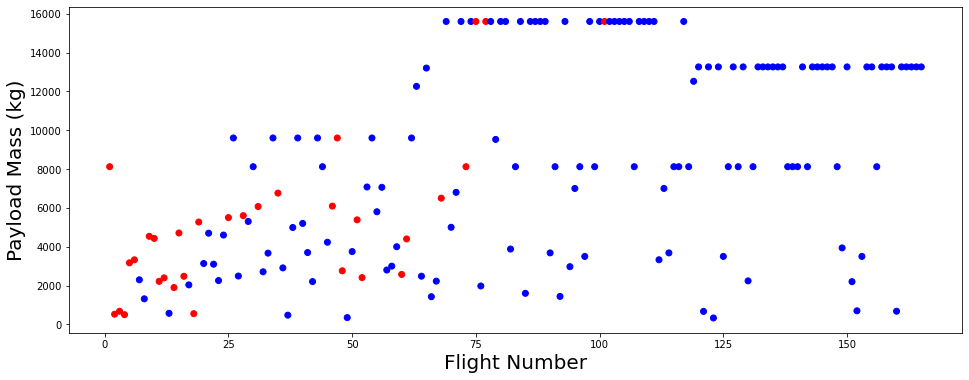

In [8]:
# Plot the successful landings in blue and failed landings in red
# 'colors' is a list of 'blue' and 'red' strings that vary according to the values of 'Class'.
# If 'Class' is 1, 'colours' is 'blue', otherwise, 'colours' will be 'red'.
colors = df['Class'].apply(lambda x: 'blue' if x==1 else 'red')

# Plotting flight number on the x-axis and payload mass on the y-axis.
plt.figure(figsize=(16,6)) # Figure size: 16 inches of width and 6 inches of height.
plt.scatter(y="PayloadMass", x="FlightNumber", c=colors, data=df)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Payload Mass (kg)",fontsize=20)
plt.show()

We see clearly that as the flight number increases, the first stage is more likely to land successfully. The payload mass is also important; it seems the more massive the payload, the more likely the first stage will land successfully.

### Launch success rate <a id='Launch_success_rate'></a>

Calculating the launch success rate is straightforward according to our data. If a successful landing outcome is registered as $1$ and a failed landing as $0$ in the `Class` variable, then the average of all `Class` values will be the success rate. 

We can quickly calculate the success rate across all launches

In [9]:
df['Class'].mean()

0.8121212121212121

and we can also calculate the success rate of launches in each launch site

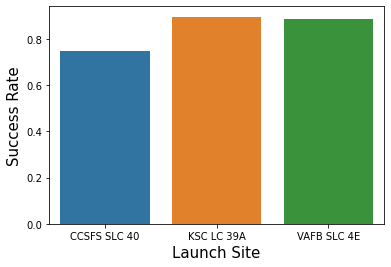

In [10]:
# Here we use the 'groupby' method on 'LaunchSite' column and get the mean of 'Class' column per launch site
site_success_rate = df['Class'].groupby(df['LaunchSite']).mean()

sns.barplot(y=site_success_rate.values, x=site_success_rate.index)
plt.xlabel("Launch Site",fontsize=15)
plt.ylabel("Success Rate",fontsize=15)
plt.show()

and also the success rate of launches of each orbit type

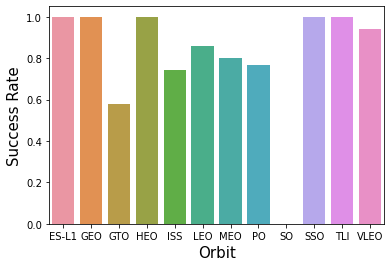

In [11]:
# Here we use the 'groupby' method on the 'Orbit' column and get the mean of 'Class' column per orbit
orbit_success_rate = df['Class'].groupby(df['Orbit']).mean()

sns.barplot(y=orbit_success_rate.values, x=orbit_success_rate.index)
plt.xlabel("Orbit",fontsize=15)
plt.ylabel("Success Rate",fontsize=15)
plt.show()

We see that different launch sites have different success rates.  <code>CCSFS SLC 40</code> has the lowest success rate.

We can also see that the only launch in the sun-synchronous `SO` orbit has failed, the only launches in `HEO` and `ES-L1` orbits have succeeded and that the success rate in the most frequently used orbit, the `VLEO`, is quite high.

### The relationship between flight number and launch site <a id='Flight_number_site'></a>

Let's check the relationship between `FlightNumber` and `LaunchSite` using another scatter plot.

The `colors` list is the same used [above](#Flight_number_payload).

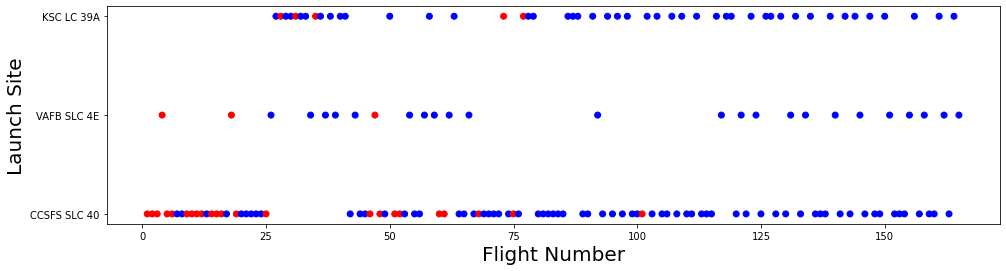

In [12]:
# Plot a scatter point chart with x axis to be Flight Number and y axis to be the launch site, and hue to be the class value
# Plotting flight number on the x-axis and payload mass on the y-axis.
plt.figure(figsize=(16,4)) # Figure size: 16 inches of width and 4 inches of height.
plt.scatter(y="LaunchSite", x="FlightNumber", c=colors, data=df)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

Here we clearly see why `CCSFS SLC 40` has the lowest launch success rate of all sites. The overwhelming majority of the first flights, which were those that failed more often, took place at this site. The pattern is quite clear for the first 25 flights.

### The relationship between payload mass and launch site <a id='Payload_launch_site'></a>

We also want to observe if there is any relationship between launch sites and their payload mass. Let's use the scatter plot again. 

The `colors` list is the same used [above](#Flight_number_payload).

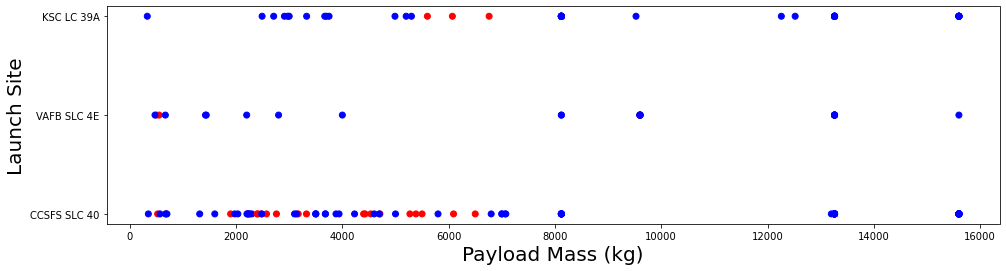

In [13]:
# Plot a scatter point chart with x axis to be 'PayloadMass' and y axis to be the 'LaunchSite'
plt.figure(figsize=(16,4)) # Figure size: 16 inches of width and 4 inches of height.
plt.scatter(y="LaunchSite", x="PayloadMass", c=colors, data=df)
plt.xlabel("Payload Mass (kg)",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

Most of the launches had a payload mass below $8000$ kg and most of these took place at `CCSFS SLC 40`.

### Launch success yearly trend <a id='Launch_success_trend'></a>

You can plot a line chart with x axis to be <code>Year</code> and y axis to be `Average success rate`, to get the average launch success trend.

We will use the `Extract_year` function described below to get the year from the date. This function uses the `Date` column, splits each date using the dash character `-`. After doing so, we will obtain three values per `Date` cell. The first one will be the `Year` and this is the one we will gather (the other two are the month and day, respectively).

In [14]:
# A function to Extract years from the date 
def Extract_year(date):
    year=[]
    for i in date:
        year.append(i.split("-")[0]) #The first element obtained from each cell after splitting the date is the year.
    return year

Now we will obtain the year from the date and allocate it into the `Year` column. Then we will use a line plot to check how success rate has changed over the years.

Text(0, 0.5, 'Success Rate')

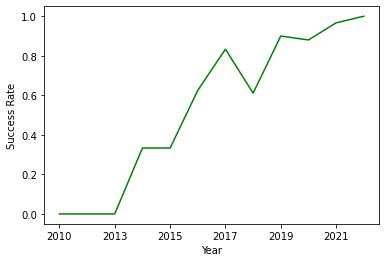

In [15]:
# Plot a line chart with x axis to be the extracted year and y axis to be the success rate
df['Year'] = Extract_year(df['Date'])
df.head()
success_rate_by_year = df['Class'].groupby(df['Year']).mean() # Average success rate by year using 'groupby' method and 'Year'
success_rate_by_year.plot(kind="line", color ='g')
plt.ylabel('Success Rate')

We can clearly see a trend for an increasing launch success rate over the years.


***

## Feature Engineering <a id='Feature_engineering'></a>

By now, we have some preliminary insights about how each important variable would affect the success rate. We will select the features that will be used in success prediction in the future module and assign this group of features to the data frame `features`.

In [16]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,8120.677431,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


### Create dummy variables from categorical predictors <a id='Dummy'></a>

We will use the function <code>get_dummies</code> and the <code>features</code> dataframe to apply `OneHotEncoder` to the to the categorical columns <code>Orbit</code>, <code>LaunchSite</code>, <code>LandingPad</code>, and <code>Serial</code>. We will assign the output table to the variable <code>features_one_hot</code>. This dataframe must include all encoded features.

In [17]:
features_one_hot = pd.get_dummies(features[['Orbit', 'LaunchSite', 'LandingPad', 'Serial']])
features_one_hot.head()

,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071,Serial_B1073
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Casting all encoded features to the numeric type `float64` <a id='Float64'></a>

Now that our <code>features_one_hot</code> data frame only contains numbers cast the entire data frame to the variable type <code>float64</code>


In [18]:
features_one_hot = features_one_hot.astype('float64')

We can now export these encoded features to a <b>CSV</b>. These will be used in model development.

In [20]:
features_one_hot.to_csv('dataset_part_3.csv', index=False)

## Acknowledgments

Lakshmi Holla

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">Joseph Santarcangelo</a>


<a href="https://www.linkedin.com/in/nayefaboutayoun/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">Nayef Abou Tayoun</a>


This exercise was based on the [Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone?specialization=ibm-data-science) course from the [IBM Data Science Professional Certificate](https://www.coursera.org/professional-certificates/ibm-data-science) specialization. However, all descriptions and code were widely extended from the model development performed during in the course.